<b>Задача:</b><br> 
выполнить кластеризацию кварталов Васильевского острова на основании предоставленных данных о границах кварталов и 
сервисах разных видов, расположенных на территории кварталов; также необходимо обосновать конечный выбор количества кластеров
и интерпретировать результаты кластеризации<br><br>
<b>Исходные данные:</b>
в качестве исходных данных из Платформы городских данных Института дизайна и урбанистики Университета ИТМО выгружены следующие массивы данных:
- blocks.geojson - данные о кварталах Васильевского острова;
- cafe.geojson - данные о местах общественного питания типа кафе;
- restaurant.geojson - данные о местах общественного питания типа ресторан;
- kindergarten.geojson - данные о детских садах;
- school.geojson - данные о школах;
- library.geojson - данные о библиотеках;
- museum.geojson - данные о музеях;
- pharmacy.geojson - данные об аптеках;
- polyclinic.geojson - данные о поликлинниках;
- shopping_center.geojson - данные о торговых центрах;
- supermarket.geojson - данные о супермаркетах;
- building.geojson - данные о зданиях (жилых и нежилых);
- cemetery.geojson - данные о кладбищах;
- znop.geojson - данные о зелёных насаждениях.

In [2]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from functools import reduce
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

<b>1 Исследовательский анализ данных</b>

<b>1.1 Данные о кварталах</b>

In [3]:
blocks_data = gpd.read_file('data/source_data/blocks.geojson')
blocks_data.head()

,id,municipality,district,geometry
0,10,Остров Декабристов,Василеостровский,"MULTIPOLYGON (((30.24774 59.94989, 30.24657 59..."
1,16,округ Морской,Василеостровский,"MULTIPOLYGON (((30.21620 59.94924, 30.22653 59..."
2,46,Васильевский,Василеостровский,"MULTIPOLYGON (((30.26647 59.94468, 30.27092 59..."
3,67,округ Морской,Василеостровский,"MULTIPOLYGON (((30.20804 59.93856, 30.20854 59..."
4,112,Васильевский,Василеостровский,"MULTIPOLYGON (((30.28385 59.94769, 30.28505 59..."


In [4]:
blocks_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            200 non-null    int64   
 1   municipality  200 non-null    object  
 2   district      200 non-null    object  
 3   geometry      200 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 6.4+ KB


In [5]:
print('Представлены кварталы районов: ', blocks_data.district.unique())

Представлены кварталы районов:  ['Василеостровский']


В выборке содержатся данные 200 кварталов, пропусков в данных нет, геометрически кварталы представляют собой полигоны.
Признак district может быть удален (все кварталы относятся к Василеостровскому району), признак municipality также
следует удалить, так как кластеризация требуется на основании данных о сервисах. В итоге для дальнейшего анализа
будут использоваться данные о номерах кварталов (id) и их геометрии (geometry). 

In [6]:
blocks_data = blocks_data[['id', 'geometry']]

<b>1.2 Данные о местах общественного питания типа кафе</b>

In [7]:
cafe_data = gpd.read_file('data/source_data/cafe.geojson')
cafe_data.head()

,yand_adr,name,type,id,amenity,x,y,geometry
0,"Россия, Санкт-Петербург, Биржевой переулок, 2",Эдда,кафе,node/3168670772,cafe,59.945017,30.293563,POINT (30.29356 59.94502)
1,"Россия, Санкт-Петербург, 6-я линия Васильевско...",Ферма,кафе,node/6355459185,cafe,59.940343,30.282262,POINT (30.28226 59.94034)
2,"Россия, Санкт-Петербург, 1-я линия Васильевско...",Столовая,столовая,node/5235334623,cafe,59.943422,30.287877,POINT (30.28788 59.94342)
3,"Россия, Санкт-Петербург, 8-я линия Васильевско...",Рамен Шифу,кафе,node/963944161,cafe,59.937607,30.282020,POINT (30.28202 59.93761)
4,"Россия, Санкт-Петербург, улица Кораблестроител...",Небесный ФУД Город,кафе,node/825152812,cafe,59.952493,30.212346,POINT (30.21235 59.95249)


In [8]:
cafe_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   yand_adr  112 non-null    object  
 1   name      112 non-null    object  
 2   type      112 non-null    object  
 3   id        112 non-null    object  
 4   amenity   112 non-null    object  
 5   x         112 non-null    float64 
 6   y         112 non-null    float64 
 7   geometry  112 non-null    geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 7.1+ KB


In [9]:
print('Типы кафе: ', cafe_data['type'].unique())

Типы кафе:  ['кафе' 'столовая']


В выборке содержатся данные 112 кафе и столовых, пропусков в данных нет, геометрически сервисы этого типа представляют собой точки.
В итоге для дальнейшего анализа будут использоваться данные о номерах кафе (id) и их геометрии (geometry).

<b>1.3 Данные о прочих "точечных" сервисах</b>

Исследовательский анализ показал (эта часть не включается в ноутбук для сокращения его размера), что к сервисам с геометрией точки также 
относятся датасеты restaurant.geojson (70 сервисов), kindergarten.geojson (49 сервисов), school.geojson (39 сервисов), library.geojson (13 сервисов), museum.geojson (26 сервисов), pharmacy.geojson (42 сервиса), polyclinic.geojson (8 сервисов) shopping_center.geojson (3 сервиса), supermarket.geojson (71 сервис). Все перечисленные датасеты имеют аналогичную структуру, не содержат пропусков, и для дальнейшего анализа будут использоваться данные id и geometry из этих датасетов.<br>
Таким образом, типов точечных сервисов много, но количество сервисов каждого из типов достаточно ограничено. Причем есть типы сервисов, очень похожие с точки зрения потребителей услуг. Например, кафе и рестораны (места общественного питания) или торговые центры и супермаркеты (места для покупок). Для сокращения количества признаков и упрощения задачи кластеризации принимается решение объединить датасеты с похожими типами сервисов.

In [10]:
# Объединение данных о кафе и ресторанах
dining_data = pd.concat([cafe_data, gpd.read_file('data/source_data/restaurant.geojson')[['id', 'geometry']]])

In [11]:
# Объединение данных о торговых центрах и супермаркетах
shopping_data = pd.concat([gpd.read_file('data/source_data/supermarket.geojson')[['id', 'geometry']],
                          gpd.read_file('data/source_data/shopping_center.geojson')[['id', 'geometry']]])

In [12]:
# Объединение данных о детских садах и школах
edu_data = pd.concat([gpd.read_file('data/source_data/kindergarten.geojson')[['id', 'geometry']],
                          gpd.read_file('data/source_data/school.geojson')[['id', 'geometry']]])

In [13]:
# Объединение данных о поликлинниках и аптеках
health_data = pd.concat([gpd.read_file('data/source_data/pharmacy.geojson')[['id', 'geometry']],
                          gpd.read_file('data/source_data/polyclinic.geojson')[['id', 'geometry']]])

In [14]:
# Объединение данных о музеях и библиотеках
culture_data = pd.concat([gpd.read_file('data/source_data/museum.geojson')[['id', 'geometry']],
                          gpd.read_file('data/source_data/library.geojson')[['id', 'geometry']]])

In [15]:
# Все точечные сервисы объединяются в словарь для дальнейшего анализа
services_points = {'culture': culture_data, 'dining': dining_data, 'educaton': edu_data, 'health': health_data, 'shopping': shopping_data}

<b>1.4 Данные о зданиях</b>

In [16]:
buildings_data = gpd.read_file('data/source_data/building.geojson')
buildings_data.tail(3)

,building_id,address,building_date,building_area,living_area,storeys,population,central_heating,lift_count,central_hotwater,central_electricity,central_gas,refusechute,is_living,geometry
4259,122614,"г.Санкт-Петербург, набережная Макарова, дом 14...",1823,159.6,32.00,2.0,2.0,True,0.0,True,True,True,True,False,"MULTIPOLYGON (((30.28992 59.94590, 30.29008 59..."
4260,122615,"г.Санкт-Петербург, 7-я линия В.О., дом 6, лите...",1917,3398.8,1437.85,5.0,63.0,True,NaN,False,True,True,False,False,"MULTIPOLYGON (((30.28387 59.93718, 30.28476 59..."
4261,122616,"г.Санкт-Петербург, Средний проспект В.О., дом ...",2011,89327.9,46407.50,16.0,2900.0,True,20.0,True,True,False,False,True,"MULTIPOLYGON (((30.25126 59.93804, 30.25180 59..."


В задаче требуется анализировать расположение только жилых зданий в кварталах, поскольку в датасете building.geojson нет 
информации о функциональной принадлежности нежилых зданий (какие сервисы в них находятся). Поэтому требуется отфильтровать 
в датасете жилые здания. После первоначального ознакомления с датасетом можно предположить, что отфильтровать следует
по признаку is_living = True. Однако при этом можно наблюдать, что у зданий с признаком is_living = False могут присутствовать 
сведения о количестве жильцов в доме (population), а также о жилой площади (living_area).

In [17]:
buildings_data.shape

(4262, 15)

In [18]:
buildings_data[buildings_data.population.notnull()][['building_id', 'population', 'living_area', 'is_living']].head()

,building_id,population,living_area,is_living
27,32990,1122.0,17958.0,False
28,33114,1831.0,29294.3,False
29,33175,151.0,2422.5,True
31,33212,1702.0,27227.9,False
33,33294,427.0,6830.8,False


In [19]:
# В связи с этим жилые здания в датасете отфильтрованы с учетом трёх признаков: is_living, population, living_area
living_builds = buildings_data.loc[(buildings_data.population.notnull()) | (buildings_data.living_area.notnull()) | (buildings_data.is_living == True)]

In [20]:
# Дальнейший анализ показал, что в датасете с жилыми зданиями есть записи с дублирующимися идентификаторами зданий
living_builds[living_builds.duplicated(subset=['building_id'])][['building_id', 'population', 'living_area', 'is_living']].head(10)

,building_id,population,living_area,is_living
13,32353,NaN,NaN,True
14,32353,NaN,NaN,True
26,32627,NaN,NaN,True
37,33505,NaN,NaN,True
38,33505,NaN,NaN,True
39,33505,NaN,NaN,True
40,33505,NaN,NaN,True
41,33505,NaN,NaN,True
42,33505,NaN,NaN,True
64,33951,NaN,NaN,True


In [21]:
# Предполагается, что наличие дублирующихся идентификаторов зданий обусловлено некачественно выполненной выгрузкой исходных данных
# Дубликаты записей исключаются из датасета
living_builds = living_builds.drop_duplicates(subset = ['building_id'])
living_builds.shape

(1903, 15)

In [22]:
living_builds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1903 entries, 10 to 4261
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   building_id          1903 non-null   int64   
 1   address              1305 non-null   object  
 2   building_date        1199 non-null   object  
 3   building_area        1199 non-null   float64 
 4   living_area          1199 non-null   float64 
 5   storeys              1231 non-null   float64 
 6   population           1199 non-null   float64 
 7   central_heating      1199 non-null   object  
 8   lift_count           513 non-null    float64 
 9   central_hotwater     1199 non-null   object  
 10  central_electricity  1199 non-null   object  
 11  central_gas          1199 non-null   object  
 12  refusechute          1199 non-null   object  
 13  is_living            1903 non-null   bool    
 14  geometry             1903 non-null   geometry
dtypes: bool(1), 

В датасете living_builds содержится довольно много информации о жилых зданиях. В частности, информация о количестве жителей зданий и количестве этажей, которую можно было бы использовать как характеристику густонаселенности квартала, в котором расположено здание. Однако в данных о количестве жителей и количестве этажей много пропусков (около 40%) и восполнить пропуски без искажения данных не представляется возможным. При этом известно, что Васильевский остров преимущественно застроен многоэтажными зданиями с минимальной малоэтажной застройкой. Поэтому по согласованию с заказчиком исследования для анализа населенности кварталов используются только сведения о геометрии жилых зданий (полигонах), прочие признаки из исследования исключаются.

In [23]:
living_builds = living_builds[['building_id', 'geometry']]

<b>1.5 Данные о прочих "полигональных" сервисах</b>

Исследовательский анализ показал (эта часть не включается в ноутбук для сокращения его размера), что оставшиеся датасеты содержат данные о сервисах с геометрией полигонов: znop.geojson (607 сервисов) и cemetery.geojson (4 сервиса). Предлагается для сокращения количества признаков объединить датасеты.

In [24]:
znop_data = pd.concat([gpd.read_file('data/source_data/cemetery.geojson')[['geometry']],
                          gpd.read_file('data/source_data/znop.geojson')[['geometry']]])

In [25]:
# Все полигональные сервисы объединяются в массив для дальнейшего анализа
services_polygons = {'living_area': living_builds, 'znop': znop_data}

На этом этапе исходные данные исследованы и обработаны. Получен датасет с данными о кварталах и массивы датасетов с данными точечных и полигональных сервисов. Далее на основании имеющихся данных будут сформированы признаки для дальнейшей кластеризации. 

<b>2 Формирование признаков</b>

In [26]:
# Датафрейм с идентификаторами кварталов для хранения признаков
blocks_data = blocks_data.rename(columns = {'id': 'block_id'})
features_df = blocks_data['block_id'].copy()

<b>2.1 Признаки на данных "точечных" сервисов</b>

По согласованию с заказчиком исследования признаки по точечным сервисам будут рассчитаны следующим образом:
- для каждого типа сервиса будет определено количество мест оказания сервиса в каждом квартале;
- на основании данных о площади кварталов будет определено удельное количество сервисов на единицу площади квартала (площади кварталов могут существенно отличаться);
- максимальное удельное количество сервисов каждого типа будет принято за 100% обеспеченности квартала сервисом, значения удельного количества сервисов каждого типа будут нормированы по максимального значению;
- таким образом, для каждого квартала будут получены удельные нормированные значения обеспеченности каждым типом сервисов, в диапазоне от 0 до 100%.  

In [27]:
# Площадь кварталов рассчитывается после перевода данных геометрии кварталов в стандартную картографическую проекцию 3857
blocks_data_3857 = blocks_data.copy()
blocks_data_3857 = blocks_data_3857.to_crs('epsg:3857')
blocks_data_3857['block_area'] = blocks_data_3857['geometry'].area
# Для задачи расчета признаков по точечным сервисам будет использована площадь квартала в км2
blocks_data['area_km'] = blocks_data_3857['block_area']/1e+06
blocks_data.head()

,block_id,geometry,area_km
0,10,"MULTIPOLYGON (((30.24774 59.94989, 30.24657 59...",0.120041
1,16,"MULTIPOLYGON (((30.21620 59.94924, 30.22653 59...",2.825957
2,46,"MULTIPOLYGON (((30.26647 59.94468, 30.27092 59...",0.319905
3,67,"MULTIPOLYGON (((30.20804 59.93856, 30.20854 59...",0.973100
4,112,"MULTIPOLYGON (((30.28385 59.94769, 30.28505 59...",0.089728


In [28]:
# Получение признаков по точечным сервисам согласно принятому алгоритму
for key in services_points.keys():
    # Рассчитать количество точечных сервисов на квартал
    dfsjoin = gpd.sjoin(blocks_data, services_points[key], how="left", predicate='intersects')[['block_id', 'area_km', 'id']]
    dfsjoin = dfsjoin.rename(columns={'id': key})
    df = dfsjoin.groupby(['block_id', 'area_km']).count().reset_index()
    # Рассчитать удельное количество сервисов на единицу площади квартала (км2 в данном случае)
    df[key] = df[key]/df['area_km']
    # Принять максимальное удельное количество сервисов за 100% и нормировать прочие значения по нему
    max_ud = df[key].max()
    df[key] = round(df[key]*100/max_ud, 2)
    df = df[['block_id', key]]
    # Включить полученный признак в датафрейм для хранения признаков
    features_df = pd.merge(features_df, df, on = 'block_id')

In [29]:
# Результата получения признаков на данных точечных сервисов
features_df.head()

,block_id,culture,dining,educaton,health,shopping
0,10,0.0,0.00,0.00,0.00,0.00
1,16,0.0,0.64,12.16,3.81,13.07
2,46,0.0,5.61,0.00,0.00,0.00
3,67,0.0,0.00,0.00,0.00,6.32
4,112,0.0,100.00,0.00,60.07,0.00


<b>2.2 Признаки на данных "полигональных" сервисов</b>

Признаки по полигональным сервисам будут рассчитаны как процент покрытия площади квартала территорией, относящейся к полгональному сервису.

In [30]:
for key in services_polygons.keys():
    # Изменить картографическую проекцию сервисов для расчета площади пересечения с кварталами
    services = services_polygons[key].to_crs('epsg:3857')
    # Сопоставить пространственные сервисы с кварталами, чтобы найти кварталы, в которых сервисы есть
    sp_dfsjoin = gpd.overlay(blocks_data_3857, services, how='intersection')
    # Вычислить площадь пересечения для каждой строки
    sp_dfsjoin['overlay_area'] = sp_dfsjoin['geometry'].area
    sp_dfsjoin = sp_dfsjoin[['block_id', 'block_area', 'overlay_area']]
    # Вычислить площадь пересечения со всеми сервисами для каждого квартала и процент пересечения
    sp_df = sp_dfsjoin.groupby(['block_id', 'block_area']).sum()
    sp_df = sp_df.reset_index()
    sp_df[key] = round((sp_df['overlay_area'] * 100 / sp_df['block_area']), 2)
    sp_df = sp_df[['block_id', key]]
    # Включить полученный признак в датафрейм для хранения признаков
    features_df = pd.merge(features_df, sp_df, how='left', on = 'block_id')

In [31]:
# Пропуски в признаках заменить на нули
features_df = features_df.fillna(0)

In [32]:
# Результаты получения признаков на данных полигональных сервисов
features_df.head()

,block_id,culture,dining,educaton,health,shopping,living_area,znop
0,10,0.0,0.00,0.00,0.00,0.00,21.22,16.42
1,16,0.0,0.64,12.16,3.81,13.07,9.64,19.34
2,46,0.0,5.61,0.00,0.00,0.00,24.11,7.77
3,67,0.0,0.00,0.00,0.00,6.32,4.11,0.00
4,112,0.0,100.00,0.00,60.07,0.00,38.64,2.34


На этом этапе сформированы признаки на данных точечных и полигональных сервисов. Далее может быть выполнена кластеризация.

<b>3 Кластеризация кварталов</b>

In [33]:
# Перечень признаков для использования при кластеризации
features = list(features_df.columns)[1:]
# Зафиксировать random_state
random_st = 12345

<b>3.1 Определение количества кластеров</b>

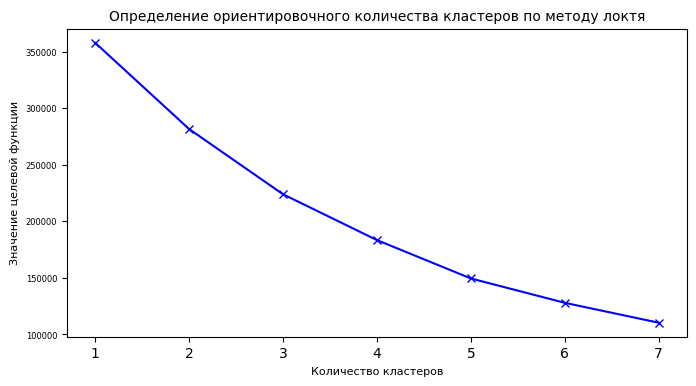

In [34]:
# Определение ориентировочного количества кластеров по методу локтя
distortion = []
K = range(1, 8)
for k in K:
    model = KMeans(n_clusters=k, random_state=random_st)
    model.fit(features_df[features])
    distortion.append(model.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, distortion, 'bx-')
plt.title('Определение ориентировочного количества кластеров по методу локтя', fontsize=10)
plt.xlabel('Количество кластеров', fontsize=8)
plt.yticks(fontsize=6)
plt.ylabel('Значение целевой функции', fontsize=8)
plt.show()

Ярко выраженного "локтя" на полученной диаграмме не наблюдается. Принимается решение провести кластеризацию для 3 и 5 кластеров и сравнить результаты.

<b>3.2 Сокращение размерности признаков</b>

Предполагается провести кластеризацию кварталов наиболее распространенным методом кластеризации k-средних с использованием модели KMeans из библиотеки scikit-learn. Метод k-средних лучше работает при низкой размерности пространства признаков, поэтому перед применением модели кластеризации будет осуществляться сокращение размерности. Для сокрашения размерности будут применены два подхода (для сравнения результатов): линейный метод главных компонент (PCA) и нелинейный метод многомерного масштабирования (MDS). Размерность предлагается снижать до 2 для последующей визуализации результата на плоскости.

In [35]:
# Функция сокращения размерности признаков
def reduce_features_dim(features_df: pd.DataFrame, method = 'PCA'):
    # method - 'PCA' (метод главных компонент), 'MDS' (многомерное масштабирование)
    if method == 'MDS':
        mds2D = MDS(n_components=2, random_state = random_st)
        reduced_df = mds2D.fit_transform(features_df)
        reduced_df = pd.DataFrame(data=reduced_df, columns=['x', 'y'])
    else:
        pca = PCA(2, random_state = random_st)
        reduced_df = pca.fit_transform(features_df)
        reduced_df = pd.DataFrame(reduced_df, columns=['x', 'y'])
    return reduced_df

<b>3.3 Кластеризация кварталов с визуализацией результатов</b>

Поскольку интерпретировать качество кластеризации в поставленной задаче при помощи количественной метрики не представляется возможным, предлагается несколько вариантов визуализации результатов для экспертной оценки. В том числе визуализация на карте, которая позволит экспертно оценить качество кластеризации с учетом знаний об анализируемой территории.  

In [36]:
# Задать рассматриваемые кластера
clusters_nums = [5,3]
# Задать цветовую шкалу
colors = ['#a9a9a9', '#85E695', '#F046B7', '#71A9FB', '#6938C9',  '#F7F580']

In [42]:
# Функция кластеризации и визуализации
def cluster_reduced_dim(clusters:int, features_df: pd.DataFrame, reduced_features: pd.DataFrame, features:list, x_dim: int, axes, red_method_name):
    # Кластеризация на признаках сокращенной размерности
    model = KMeans(n_clusters=clusters, random_state=12345)
    model.fit(reduced_features)

    # "Обходной маневр" - фиксация цветов по опорным кварталам для удобства визуального анализа (цвета распределены на основании наблюдений в 
    # ранее проведенных экспериментах). В противном случае в разных экспериментах один и тот же по смыслу кластер получит разные цвета (так как номера
    # одинаковых по смыслу кластеров в разных экспериментах могут быть разные).
    features_df.loc[:, 'label'] = model.labels_
    df_bits = []
    order = 3
    for k in sorted(features_df.label.unique()):
        df = features_df[features_df.label == k]
        # Если выделенный кластер относится к "пустым" кварталам
        if 2750 in list(df.block_id.unique()):
            df['new_label'] = 0
        # Если выделенный кластер относится к знопам
        elif 2744 in list(df.block_id.unique()):
            df['new_label'] = 1
        # Если выделенный кластер относится к кластеру с максимумом сервисов
        elif 112 in list(df.block_id.unique()):
            df['new_label'] = 2
        else:
            df['new_label'] = order
            order+=1
        df_bits.append(df)
    features_df = pd.concat(df_bits)
    features_df['label'] =  features_df['new_label']
    features_df = features_df.drop('new_label', axis = 1)

    # 1 Визуализировать кластера на координатной плоскости
    reduced_features['label'] = features_df['label']
    for i in sorted(reduced_features.label.unique()):
        single_cluster = reduced_features[reduced_features['label'] == i]
        axes[0,x_dim].scatter(single_cluster['x'], single_cluster['y'], label=i, s=20, color=colors[i])
    axes[0,x_dim].set_title(f'Кластеров: {clusters}, метод сокращения признаков: {red_method_name}', fontsize = 14)

    # 2 Визуализировать кластера на карте (используется библиотека folium с подложкой OSM)
    m = folium.Map(location=(59.9390, 30.2500), zoom_start=13)
    features_means = []
    i = 0
    # Создать отдельные geojsons для каждого кластера кварталов
    for k in sorted(features_df.label.unique()):
        df = features_df[features_df.label == k]
        block_ids = list(df.block_id.unique())
        blocks = blocks_data[blocks_data.block_id.isin(block_ids)]
        blocks['cluster'] = k
        # Получить датафрейм средних значений признаков для каждого кластера
        a = df[features].mean(axis=0)
        adf = pd.DataFrame({'feature': a.index, f'cluster_{k}': a.values})
        features_means.append(adf)
        # Добавить слой кварталов кластера на карту с разной раскраской для каждого кластера
        folium.GeoJson(blocks,
                       style_function=lambda x: {'fillColor': '#a9a9a9' if x['properties']['cluster'] == 0
                       else ('#85E695' if x['properties']['cluster'] == 1
                             else ('#F046B7' if x['properties']['cluster'] == 2
                                   else ('#71A9FB' if x['properties']['cluster'] == 3
                                         else ('#6938C9' if x['properties']['cluster'] == 4 else '#F7F580')))),
                                                 'weight': 0.1, 'fillOpacity': 0.6}).add_to(m)

    # Сохранить карту с нанесенными кластерами
    m.save(f"data/blocks_by_{clusters}_clusters_{red_method_name}.html")

    # 3 Построить столбчатую диаграмму средних значений фич для кластеров
    means_df = reduce(lambda left, right: pd.merge(left, right, on=['feature'], how='inner'), features_means)
    means_df.plot(x='feature', y=list(means_df.columns)[1:], kind='barh', color=colors, width=0.8,
                  ax= axes[1,x_dim])
    axes[1,x_dim].set_title('Средние значения признаков по кластерам', fontsize = 10)
    axes[1, x_dim].set(xlabel = 'Среднее значение признака в % обеспеченности', ylabel = None)
    return None

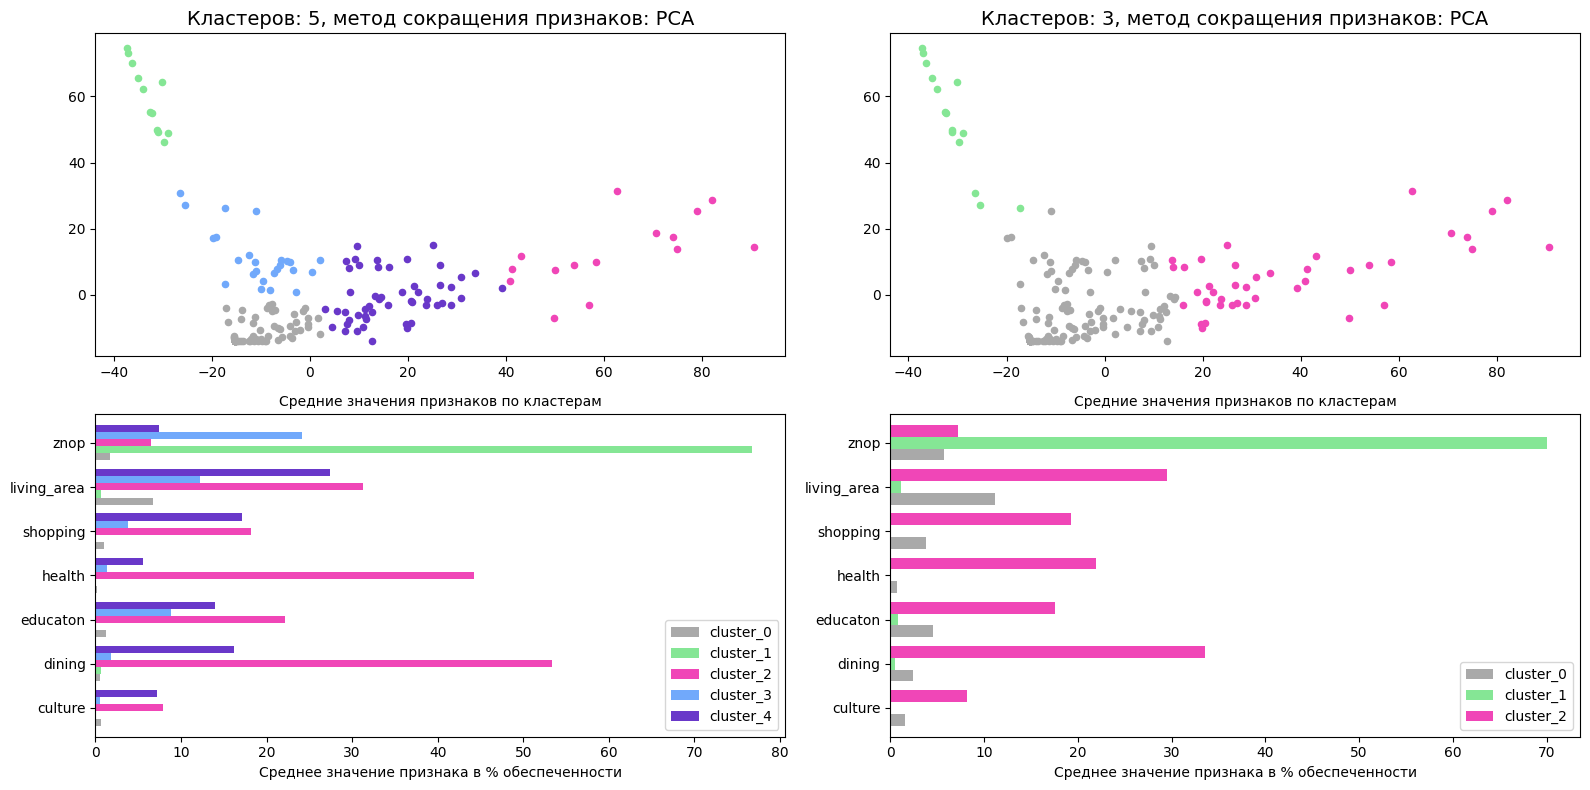

In [43]:
# Кластеризация после сокращения размерности признаков методом главных компонент
fig1, axes1 = plt.subplots(2, len(clusters_nums), squeeze = True, figsize = (16,8))
reduce_method = 'PCA'
# Сокращение размерности признаков
reduced_features_pca = reduce_features_dim(features_df[features], reduce_method)
# Кластеризация с визуализацией результатов для выбранных количеств кластеров
for j in range(len(clusters_nums)):
    cluster_reduced_dim(clusters_nums[j], features_df, reduced_features_pca, features, j, axes1, reduce_method)
fig1.tight_layout()
plt.show()

Визуализация 5 кластеров на карте PCA (для 3 кластеров визуализация также представлена в папке data):<br><br>
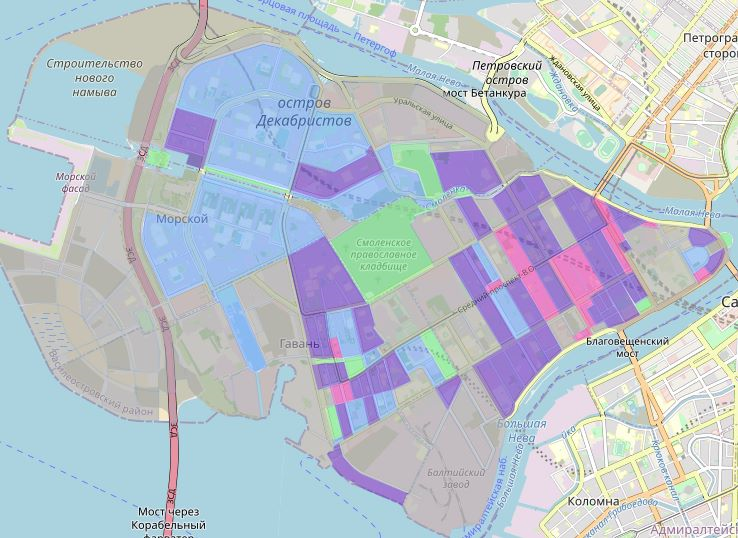

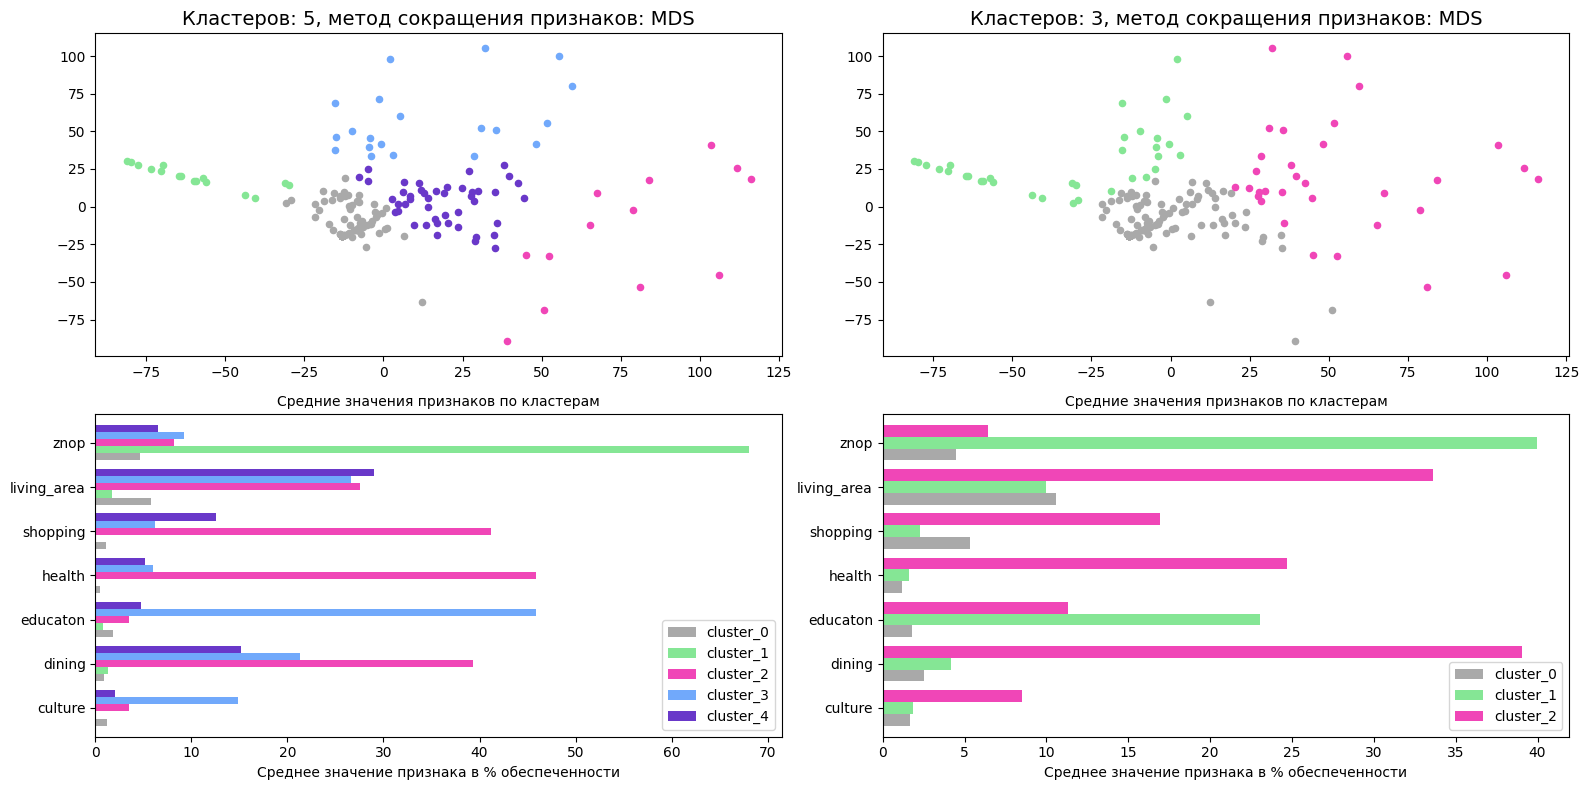

In [44]:
# Кластеризация после сокращения размерности признаков методом многомерного масштабирования
fig2, axes2 = plt.subplots(2, len(clusters_nums), squeeze = True, figsize = (16,8))
reduce_method2 = 'MDS'
# Сокращение размерности признаков
reduced_features_mds = reduce_features_dim(features_df[features], reduce_method2)
# Кластеризация с визуализацией результатов для выбранных количеств кластеров
for j in range(len(clusters_nums)):
    cluster_reduced_dim(clusters_nums[j], features_df, reduced_features_mds, features, j, axes2, reduce_method2)
fig2.tight_layout()
plt.show()

Визуализация 5 кластеров на карте PCA (для 3 кластеров визуализация также представлена в папке data):<br><br>
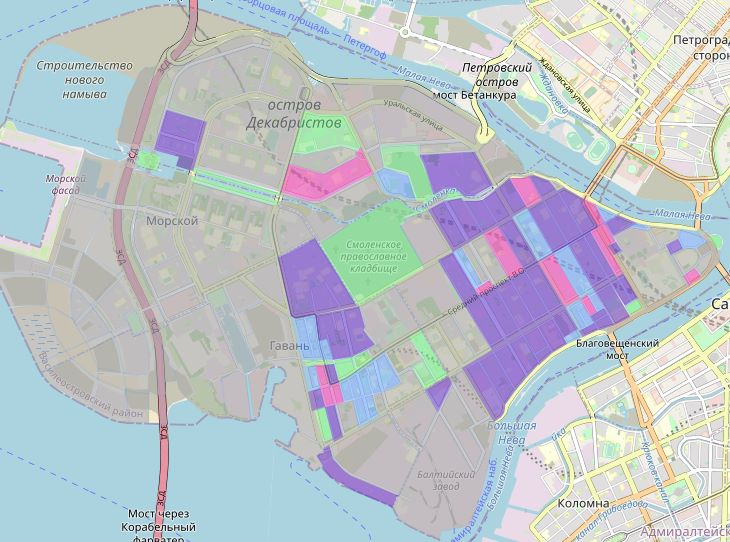

<b>4 Выводы</b>

Можно видеть, что результаты кластеризации при сокращении размерности признаков методами PCA и MDS достаточно похожи. Во всех проведенных экспериментах выделяется кластер "пустых кварталов" (серый цвет), где мало всех видов сервисов, знопов и жилой застройки. Также во всех экспериментах, кроме эксперимента с 3мя кластерами и методом MDS, четко выделяется кластер знопов (зелёный цвет). Третьим во всех экспериментах был выделен кластер кварталов с большим количеством разнообразных сервисов и жилой застройки, то есть кластер наиболее развитых кварталов. При увеличении количества кластеров появляются кластера со "средним" количеством сервисов и жилой застройки.<br>
В результате экспертной оценки полученных результатов предпочтительным принимается метод сокращения размерности признаков PCA, а количество кластеров предлагается выбирать в зависимости от цели использования результатов кластеризации: 3 кластера для самой "грубой" кластеризации кварталов, 4 или 5 кластеров - для получения более тонких градаций.